In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_meta_path = data_dir /'13cyc'  / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)


# PLA quantification

In [8]:
import PLA

PPI_save_path =  data_dir / '13cyc'  / 'PPI'
PPI_save_path.mkdir(parents=True, exist_ok=True)

PPI_imgs_path =  data_dir / '13cyc'  / 'PPI_imgs'
PPI_imgs_path.mkdir(parents=True, exist_ok=True)

In [6]:
for row in df_imgs.itertuples():
    path = row.Path
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
    print(markers)
    break


['Hoechst' 'Sox2/Oct4' 'NF-Kb/p-P90rsk' 'Hoechst' 'SIRT1/P53' 'TRAIL/DR5'
 'Hoechst' 'Cyclin D1/CDK4' 'Bim/Tom20' 'Hoechst' 'EGFR/GRB2' 'FoxO1/AKT'
 'Hoechst' 'p-ERK/c-MYC' 'Hoechst' 'Mcl-1/BAK' 'Hoechst' 'Cyclin E/CDK2'
 'Hoechst' 'AKT/Mtor' 'Hoechst' 'TEAD1/YAP' 'Hoechst' 'p-EGFR'
 'Phalloidin' 'Ki67' 'Hoechst' 'NBD-C6' 'COX IV' 'Hoechst'
 'Pan-cytokeratin' 'Hoechst' 'Concanavalin A' 'WGA']


In [7]:
PPI_markers = ['Sox2/Oct4', 'NF-Kb/p-P90rsk', 'SIRT1/P53', 'TRAIL/DR5',
 'Cyclin D1/CDK4', 'Bim/Tom20', 'EGFR/GRB2', 'FoxO1/AKT',
 'p-ERK/c-MYC', 'Mcl-1/BAK', 'Cyclin E/CDK2',
 'AKT/Mtor', 'TEAD1/YAP']

In [ ]:
for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    pla_detect = PLA.PLA_detection(path, name='imgs', m='Marker')
    
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        
    imgs_spots = []
    imgs_wths = []
    imgs_raw = []
    for RNA in PPI_markers: 
        if RNA in markers:
            img_spot, img_wth, _, img = pla_detect.detect_spot(RNA, thres=0.03, min_radius=2)
            imgs_spots.append(img_spot)
            imgs_wths.append(img_wth)
            imgs_raw.append(img)

    # Save imgs
    file_path = PPI_imgs_path / ('_'.join(row[1:3]) + '_raw.tiff')
    tiff.imwrite(file_path, imgs_raw)
    file_path = PPI_imgs_path / ('_'.join(row[1:3]) + '_processed.tiff')
    tiff.imwrite(file_path, imgs_wths)
    file_path = PPI_imgs_path / ('_'.join(row[1:3]) + '_detected.tiff')
    tiff.imwrite(file_path, imgs_spots)

    # Save PPI dict
    name = '_'.join(row[1:3]) +'.pkl'
    pla_detect.save_pickle(PPI_save_path / name)

Reading image Sox2/Oct4
Processing image Sox2/Oct4
(array([0, 1], dtype=uint8), array([29107240,    87595], dtype=int64))
Reading image NF-Kb/p-P90rsk
Processing image NF-Kb/p-P90rsk
(array([0, 1], dtype=uint8), array([29070145,   124690], dtype=int64))
Reading image SIRT1/P53
Processing image SIRT1/P53
(array([0, 1], dtype=uint8), array([29178361,    16474], dtype=int64))
Reading image TRAIL/DR5
Processing image TRAIL/DR5
(array([0, 1], dtype=uint8), array([28484411,   710424], dtype=int64))
Reading image Cyclin D1/CDK4
Processing image Cyclin D1/CDK4
(array([0, 1], dtype=uint8), array([28992181,   202654], dtype=int64))
Reading image Bim/Tom20
Processing image Bim/Tom20
(array([0, 1], dtype=uint8), array([29093443,   101392], dtype=int64))
Reading image EGFR/GRB2
Processing image EGFR/GRB2
(array([0, 1], dtype=uint8), array([28914124,   280711], dtype=int64))
Reading image FoxO1/AKT
Processing image FoxO1/AKT
(array([0, 1], dtype=uint8), array([29004544,   190291], dtype=int64))
Read

In [ ]:
# import napari

# viewer = napari.view_image(np.stack(imgs_wths))
# viewer.add_image(p.stack(imgs_raw))
# viewer.add_image(np.stack(imgs_spots), contrast_limits=[0,1], blending='additive')

<Image layer 'Image [2]' at 0x1f30f044220>

# QC segmentation

In [20]:
from skimage import morphology, measure
from skimage.segmentation import clear_border
from collections import defaultdict
   
def count_pixel_label_mask(regionmask, intensity_image):
    v,c = np.unique(intensity_image[regionmask], return_counts=True)
    return dict(zip(v,c))
    
# Quality control of mask
def qc_nuclei(mask_cyto, mask_nuclei, small_size=10000):
    '''
    Function to check if cell masks contain nuclei
    '''
    # Dictionnary storing nuclei and cyto label to cell id 
    nuclei2cell = {}
    cyto2cell = {}
    
    # Filter out small objects
    mask_cyto = morphology.remove_small_objects(mask_cyto,  min_size=small_size)
    
    # Filter out mask touching border
    mask_cyto = clear_border(mask_cyto)
    
    # Filtered only cell mask region
    cell_mask = np.where(mask_cyto > 0, 1, 0)
    mask_nuclei_filtered = mask_nuclei * cell_mask
    mask_nuclei_filtered =  morphology.remove_small_objects(mask_nuclei_filtered,  min_size=2000)
    
    nuclei_mask = np.where(mask_nuclei>0, 1, 0)
    cyto = (mask_cyto - mask_cyto*nuclei_mask).astype(np.uint16)
    
    # Count pixel cell label in each nuclei region to assign each nuclei to cell
    props = measure.regionprops(mask_nuclei_filtered, intensity_image=mask_cyto, 
                    extra_properties=(count_pixel_label_mask,))
    nuclei_labels = []
    cell_labels = []
    for prop in props:
        df = pd.DataFrame.from_dict(prop['count_pixel_label_mask'], orient='index').reset_index()
        df.columns = ['Label', 'Count']
        corresponding_label = df.iloc[df['Count'].argmax(axis=0)]['Label']
        nuclei_labels.append(prop['Label'])
        cell_labels.append(corresponding_label)
    
    df = pd.DataFrame({'Nuclei': nuclei_labels, 'Cyto': cell_labels})
    return mask_cyto, mask_nuclei_filtered, cyto, df

In [21]:
# Read masks paths 
mask_dir = data_dir / '13cyc'  / 'imgs' / 'masks'
mask_filt_dir = data_dir / '13cyc'   / 'imgs' / 'masks_filtered'
mask_filt_dir.mkdir(parents=True, exist_ok=True)

masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_dir / path
    else:
        masks_path[name]['cyto'] = mask_dir / path


In [22]:
for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    name = '_'.join([row.Condition, row.FOV])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cyto']
    mask_nuclei_path = masks_path[name]['nuclei']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    mask_nuclei = mask_nuclei[:mask_cyto.shape[0], :mask_cyto.shape[1]]
    cell, nuclei, cyto, df = qc_nuclei(mask_cyto, mask_nuclei)
    
    file_path =  mask_filt_dir / f'Nuclei_{name}.tif'
    tiff.imwrite(file_path, nuclei)
    file_path =  mask_filt_dir / f'Cell_{name}.tif'
    tiff.imwrite(file_path, cell)
    file_path =  mask_filt_dir / f'Cyto_{name}.tif'
    tiff.imwrite(file_path, cyto)
    file_path =  mask_filt_dir / f'df_{name}.csv'
    df.to_csv(file_path, index=False)

# Extract per cell PPI count

In [26]:
import pickle 

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def create_PPI_df(PPI_labels, PPI_loc, name, cyto=True):
    if cyto:
        columns_name = ['Cyto', 'x', 'y']
    else:
        columns_name = ['Nuclei', 'x', 'y']
    df = pd.DataFrame(np.hstack([PPI_labels[:,np.newaxis], PPI_loc]), 
                      columns=columns_name)
    df['PPI'] = name
    return df

In [30]:
mask_filt_dir = data_dir / '13cyc' / 'imgs' / 'masks_filtered'
PPI_save_path =  data_dir / '13cyc'  / 'PPI'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [33]:
for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    df_cell_info = pd.read_csv(df_path)
    nuclei2cell = dict(zip(df_cell_info.iloc[:,0], df_cell_info.iloc[:,1]))   
    
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')
    dfs_PPI_cyto = []
    dfs_PPI_nuclei = []
    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)
        
        # Cyto
        PPI_labels = mask_cyto[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k)
        dfs_PPI_cyto.append(df_PPI)
        
        # Nuclei
        PPI_labels = mask_nuclei[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k, cyto=False)
        dfs_PPI_nuclei.append(df_PPI)
    
    # Combined DFs
    df_PPI_cyto = pd.concat(dfs_PPI_cyto)
    df_PPI_nuclei = pd.concat(dfs_PPI_nuclei)
    df_PPI_nuclei['Nuclei_Cell'] = df_PPI_nuclei['Nuclei'].apply(lambda x: nuclei2cell.get(x,x))   
    df_merged = df_PPI_cyto.merge(df_PPI_nuclei)
    df_merged['Condition'] = row[1]
    df_merged['FOV'] = row[2]
    
    # Save dataframe
    path = PPI_save_path / f'{name}.csv'
    df_merged.to_csv(path, index=False)

# Extract cell contours

In [5]:
from skimage import measure
import cv2 

def get_contours_mask(mask):
    contours = []
    labels = []
    for l in tqdm(np.unique(mask)):
        if l == 0:
            continue
        contours.append(measure.find_contours((mask==l).astype(np.uint8), 0.8))
        labels.append(l)
    return contours, labels

def replace_with_dict2(ar, dic):
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()
    
    ks = k[sidx]
    vs = v[sidx]
    return vs[np.searchsorted(ks,ar)]

In [6]:
mask_filt_dir = data_dir / '13cyc' / 'imgs' / 'masks_filtered'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

masks_path

defaultdict(dict,
            {'100nM_FW1': {'cell': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/13cyc/imgs/masks_filtered/Cell_100nM_FW1.tif'),
              'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/13cyc/imgs/masks_filtered/Cyto_100nM_FW1.tif'),
              'df': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/13cyc/imgs/masks_filtered/df_100nM_FW1.csv'),
              'nuclei': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/13cyc/imgs/masks_filtered/Nuclei_100nM_FW1.tif')},
             '100nM_FW2': {'cell': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/13cyc/imgs/masks_filtered/Cell_100nM_FW2.tif'),
              'cyto': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/13cyc/imgs/masks_filtered/Cyto_100nM_FW2.tif'),
              'df': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/13cyc/imgs/masks_filtered/df_100nM_FW2.csv'),
              'nuclei': WindowsPath('y:/coskun-lab/Thomas/23_PLA_revision/data/13cyc

In [7]:
contour_save_path =  data_dir / '13cyc' / 'contours'
contour_save_path.mkdir(parents=True, exist_ok=True)

for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    df_cell_info = pd.read_csv(df_path)
    nuclei2cell = dict(zip(df_cell_info.iloc[:,0], df_cell_info.iloc[:,1]))   
    replaced = replace_with_dict2(mask_nuclei, nuclei2cell)
    
    # Extract contours
    contours_cyto, labels_cyto = get_contours_mask(mask_cyto)
    contours_nuclei, labels_nuclei = get_contours_mask(replaced)
    
    # Save data
    save_path = contour_save_path / (name+'.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump([contours_cyto, labels_cyto, contours_nuclei, labels_nuclei], 
                    f, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/534 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/684 [00:00<?, ?it/s]

  0%|          | 0/409 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

# Extract Coexpression between IF and PPI markers

In [146]:
from functools import partial

def read_mean_pixels(x, y, window_size, path):
    x_min = np.clip(x-window_size,a_min=0, a_max=None)
    x_max = x+window_size
    y_min = np.clip(y-window_size, a_min=0, a_max=None)
    y_max = y+window_size
    
    with h5py.File(path, "r") as f:
        pixels = f['imgs'][:, y_min:y_max, x_min:x_max]
    mean_expression = pixels.mean(axis=(1,2))
    return mean_expression
    
def extract(df, path, window_size=5):
    x = df['x'].to_numpy()
    y = df['y'].to_numpy()
    
    # Read markers name 
    with h5py.File(path, "r") as f:
        markers = f['imgs'].attrs['Marker']
    
    # Define partial and joblib
    read_partial = partial(read_mean_pixels, window_size=window_size, path=path)
    mean_expressions = Parallel(n_jobs=20)(delayed(read_partial)(i,j) for i,j in zip(y,x))
    
    # create dataframe
    _, indices = np.unique(markers, return_index=True)
    indices.sort()
    marker_unique = markers[indices]
    mean_expressions = np.stack(mean_expressions)
    df_exp = pd.DataFrame(mean_expressions[:, indices], columns=marker_unique)
    return df_exp

In [147]:
# Read PPI
PPI_save_path =  data_dir / '13cyc' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)
df.reset_index(inplace=True, drop=True)
df_fil = df[df.Cyto > 0]

In [149]:
# Get Co-expression data
PPI_exp_path =  data_dir / '13cyc' / 'PPI' / 'expression'
PPI_exp_path.mkdir(parents=True, exist_ok=True)

group = df_fil.groupby(['Condition', 'FOV'])

for name, df_group in group:
    path = df_imgs[(df_imgs.Condition == name[0]) & (df_imgs.FOV == name[1])].Path.item()
    df_expression = extract(df_group, path)
    
    df_merged = pd.concat([df_group.reset_index().rename({'index':'Original Index'}, axis=1), 
                           df_expression], axis=1)
    
    # Save coexpression
    file_name = '_'.join(name)
    save_path = PPI_exp_path / f'{file_name}.csv'
    df_merged.to_csv(save_path)

# Quantification

In [9]:
# Read PPI
PPI_save_path =  data_dir / '13cyc' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Get nuclei and cell count
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']
df_cell = (df_cell.pivot_table(values='Count_cell', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_cell', var_name='PPI')
)

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei_Cell']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Nuclei', 'Count Nuclei']
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']
df_nuclei = (df_nuclei.pivot_table(values='Count_nuclei', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_nuclei', var_name='PPI')
)

# Combine count
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)
df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei'],'Count_cell'] = df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei']]['Count_nuclei']
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [10]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe()

count       mean        std  min    25%   50%  \
Condition PPI                                                              
100nM     AKT/Mtor        1110.0   1.846847   1.890120  0.0   0.25   1.0   
          Bim/Tom20       1110.0   3.229730   2.435538  0.0   1.00   3.0   
          Cyclin D1/CDK4  1110.0   6.827928   4.254328  0.0   4.00   6.0   
          Cyclin E/CDK2   1110.0   3.698198   2.955928  0.0   2.00   3.0   
          EGFR/GRB2       1110.0  10.140541   6.359962  0.0   6.00   9.0   
          FoxO1/AKT       1110.0   6.463063   4.269335  0.0   4.00   6.0   
          Mcl-1/BAK       1110.0   2.155856   2.089528  0.0   1.00   2.0   
          NF-Kb/p-P90rsk  1110.0   3.827928   3.187291  0.0   2.00   3.0   
          SIRT1/P53       1110.0   0.577477   0.836949  0.0   0.00   0.0   
          Sox2/Oct4       1110.0   2.706306   2.112323  0.0   1.00   2.0   
          TEAD1/YAP       1110.0   1.877477   1.939885  0.0   0.00   1.0   
          TRAIL/DR5       1110.0  24.714414  13.190922  0.0  16.00  23.0   
          p-ERK/c-MYC     1110.0  17.055856  19.638770  0.0   4.00  10.0   
control   AKT/Mtor        1126.0   1.655417   2.021287  0.0   0.00   1.0   
          Bim/Tom20       1126.0   4.126998   3.072869  0.0   2.00   4.0   
          Cyclin D1/CDK4  1126.0   9.818828   5.828134  0.0   6.00   9.0   
          Cyclin E/CDK2   1126.0   3.971581   3.680470  0.0   2.00   3.0   
          EGFR/GRB2       1126.0  15.674067   8.323321  0.0  10.00  14.0   
          FoxO1/AKT       1126.0   6.929840   5.263835  0.0   3.00   6.0   
          Mcl-1/BAK       1126.0   2.992007   2.425224  0.0   1.00   3.0   
          NF-Kb/p-P90rsk  1126.0   6.414742   4.617966  0.0   3.00   6.0   
          SIRT1/P53       1126.0   0.764654   0.969139  0.0   0.00   1.0   
          Sox2/Oct4       1126.0   4.664298   3.371133  0.0   2.00   4.0   
          TEAD1/YAP       1126.0   2.355240   3.334120  0.0   1.00   2.0   
          TRAIL/DR5       1126.0  25.796625  15.225722  0.0  17.00  24.0   
          p-ERK/c-MYC     1126.0   9.414742  19.724622  0.0   0.00   0.0   

                           75%    max  
Condition PPI                          
100nM     AKT/Mtor         3.0   17.0  
          Bim/Tom20        5.0   15.0  
          Cyclin D1/CDK4   9.0   44.0  
          Cyclin E/CDK2    5.0   24.0  
          EGFR/GRB2       13.0   74.0  
          FoxO1/AKT        9.0   34.0  
          Mcl-1/BAK        3.0   27.0  
          NF-Kb/p-P90rsk   5.0   39.0  
          SIRT1/P53        1.0    5.0  
          Sox2/Oct4        4.0   20.0  
          TEAD1/YAP        3.0   15.0  
          TRAIL/DR5       31.0   92.0  
          p-ERK/c-MYC     23.0  118.0  
control   AKT/Mtor         2.0   15.0  
          Bim/Tom20        6.0   35.0  
          Cyclin D1/CDK4  12.0   76.0  
          Cyclin E/CDK2    5.0   54.0  
          EGFR/GRB2       20.0   69.0  
          FoxO1/AKT        9.0   68.0  
          Mcl-1/BAK        4.0   19.0  
          NF-Kb/p-P90rsk   9.0   60.0  
          SIRT1/P53        1.0    8.0  
          Sox2/Oct4        6.0   38.0  
          TEAD1/YAP        3.0   65.0  
          TRAIL/DR5       32.0  232.0  
          p-ERK/c-MYC     11.0  168.0

In [11]:
# Filter out by maximum number of counts per cell
min_count = 0
max_count = 50

df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: x['Count_cell'].sum() > min_count)
df_all = df_all.groupby(['Condition', 'FOV', 'Id']).filter(lambda x: (x['Count_cell'] < max_count).all())
df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


C:\Users\thu71\AppData\Local\Temp\ipykernel_64740\2812454438.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_all.groupby(['Condition', 'FOV', 'Id']).sum().describe()


Count_cell  Count_nuclei   Count_cyto
count  2007.000000   2007.000000  2007.000000
mean     79.541106     35.506726    44.034380
std      32.658589     19.951232    20.711938
min       1.000000      0.000000     1.000000
25%      57.000000     22.000000    29.000000
50%      77.000000     34.000000    41.000000
75%      99.000000     48.000000    55.000000
max     208.000000    117.000000   172.000000

In [12]:
# # ONline consider positive count
df_all = df_all[df_all['Count_cyto']>=0]

In [13]:
# Describe statistics
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe().to_excel(data_dir / '13cyc' / 'metadata' / 'stats.xlsx')

In [14]:
df_all.groupby(['Condition', 'PPI'])['Count_cell'].describe().to_clipboard()

## Comparison between condition

In [15]:
from statannotations.Annotator import Annotator

def plot(plotting, figsize=(15,7), y_title='Count PPI per cell'):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
        result = annot.apply_test().annotate()
        ax.set_ylabel(y_title, fontsize=40)
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Sox2/Oct4_100nM vs. Sox2/Oct4_control: Mann-Whitney-Wilcoxon test two-sided, P_val:2.643e-53 U_stat=3.055e+05
TEAD1/YAP_100nM vs. TEAD1/YAP_control: Mann-Whitney-Wilcoxon test two-sided, P_val:2.960e-02 U_stat=4.756e+05
TRAIL/DR5_100nM vs. TRAIL/DR5_control: Mann-Whitney-Wilcoxon test two-sided, P_val:1.417e-01 U_stat=4.841e+05
p-ERK/c-MYC_100nM vs. p-ERK/c-MYC_control: Mann-Whitney-Wilcoxon test two-sided, P_val:1.223e-82 U_stat=7.485e+05
SIRT1/P53_100nM vs. SIRT1/P53_control: Mann-Whitney-Wilcoxon test two-sided, P_val:7.642e-07 U_stat=4.459e+05
Bim/Tom20_100nM vs. Bim/Tom20_control: Mann-Whitney-Wilcoxon test two-sided, P_val:1.514e-12 U_stat=4.123e+05
AKT/Mtor_100nM vs. AKT/Mtor_control: Mann-Whitney-Wilcoxon test two-sided, P_val:1.411e-07 U_stat=5.694e+05
Cyclin D1/CDK4_100nM vs. Cyclin D1/C

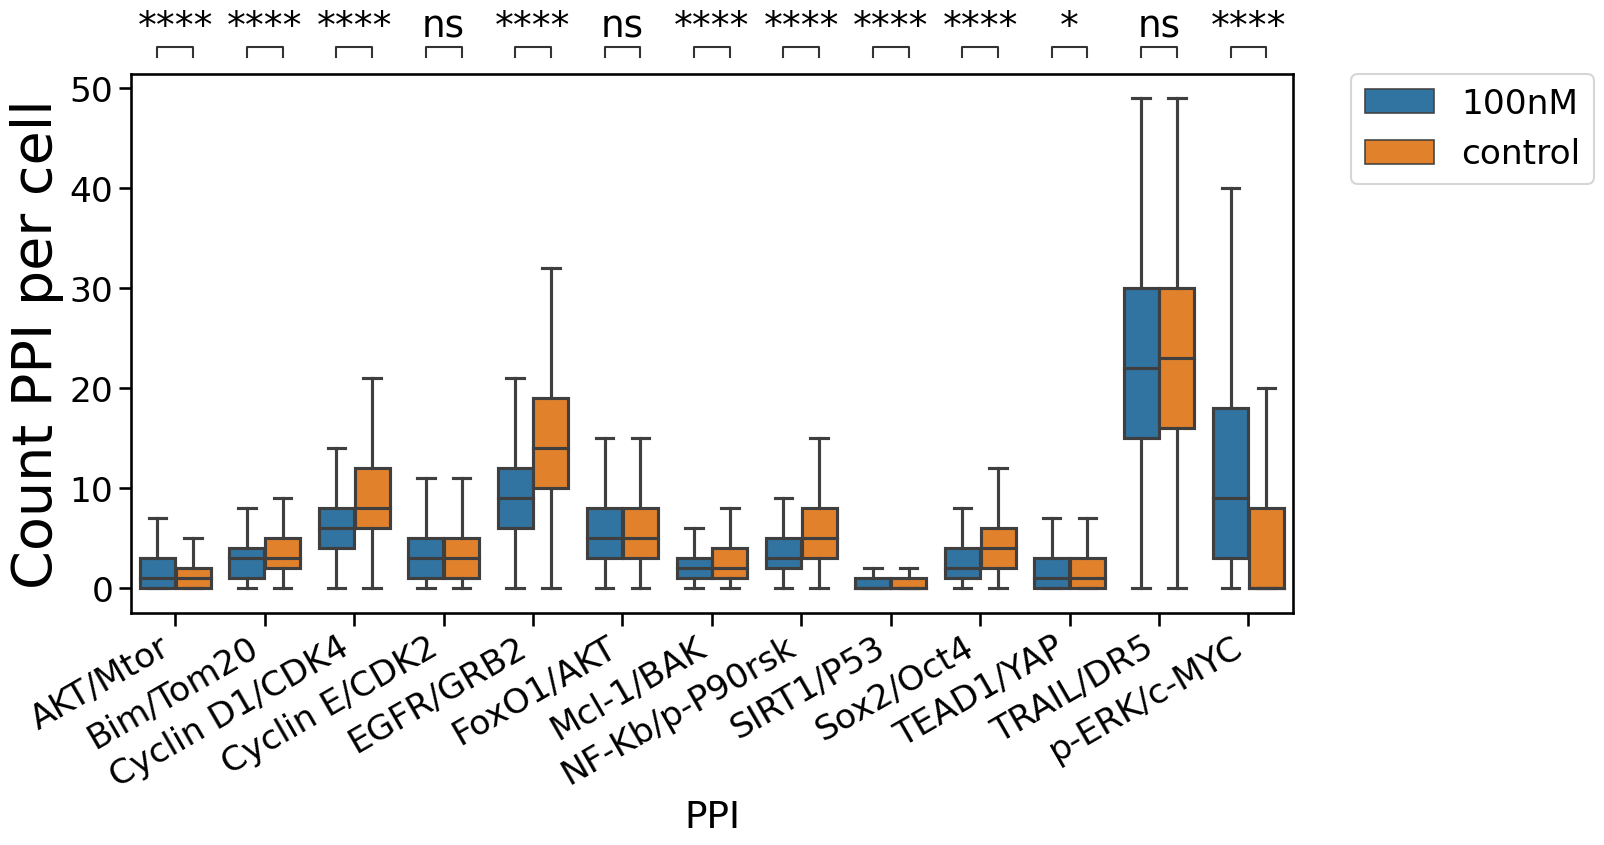

In [14]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cell",
    "hue": "Condition"
}

plot(plotting)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Sox2/Oct4_100nM vs. Sox2/Oct4_control: Mann-Whitney-Wilcoxon test two-sided, P_val:1.977e-44 U_stat=3.289e+05
TEAD1/YAP_100nM vs. TEAD1/YAP_control: Mann-Whitney-Wilcoxon test two-sided, P_val:2.973e-03 U_stat=4.678e+05
TRAIL/DR5_100nM vs. TRAIL/DR5_control: Mann-Whitney-Wilcoxon test two-sided, P_val:2.336e-01 U_stat=4.877e+05
p-ERK/c-MYC_100nM vs. p-ERK/c-MYC_control: Mann-Whitney-Wilcoxon test two-sided, P_val:4.192e-50 U_stat=6.872e+05
SIRT1/P53_100nM vs. SIRT1/P53_control: Mann-Whitney-Wilcoxon test two-sided, P_val:3.392e-15 U_stat=4.279e+05
Bim/Tom20_100nM vs. Bim/Tom20_control: Mann-Whitney-Wilcoxon test two-sided, P_val:3.615e-15 U_stat=4.036e+05
AKT/Mtor_100nM vs. AKT/Mtor_control: Mann-Whitney-Wilcoxon test two-sided, P_val:6.330e-02 U_stat=5.249e+05
Cyclin D1/CDK4_100nM vs. Cyclin D1/C

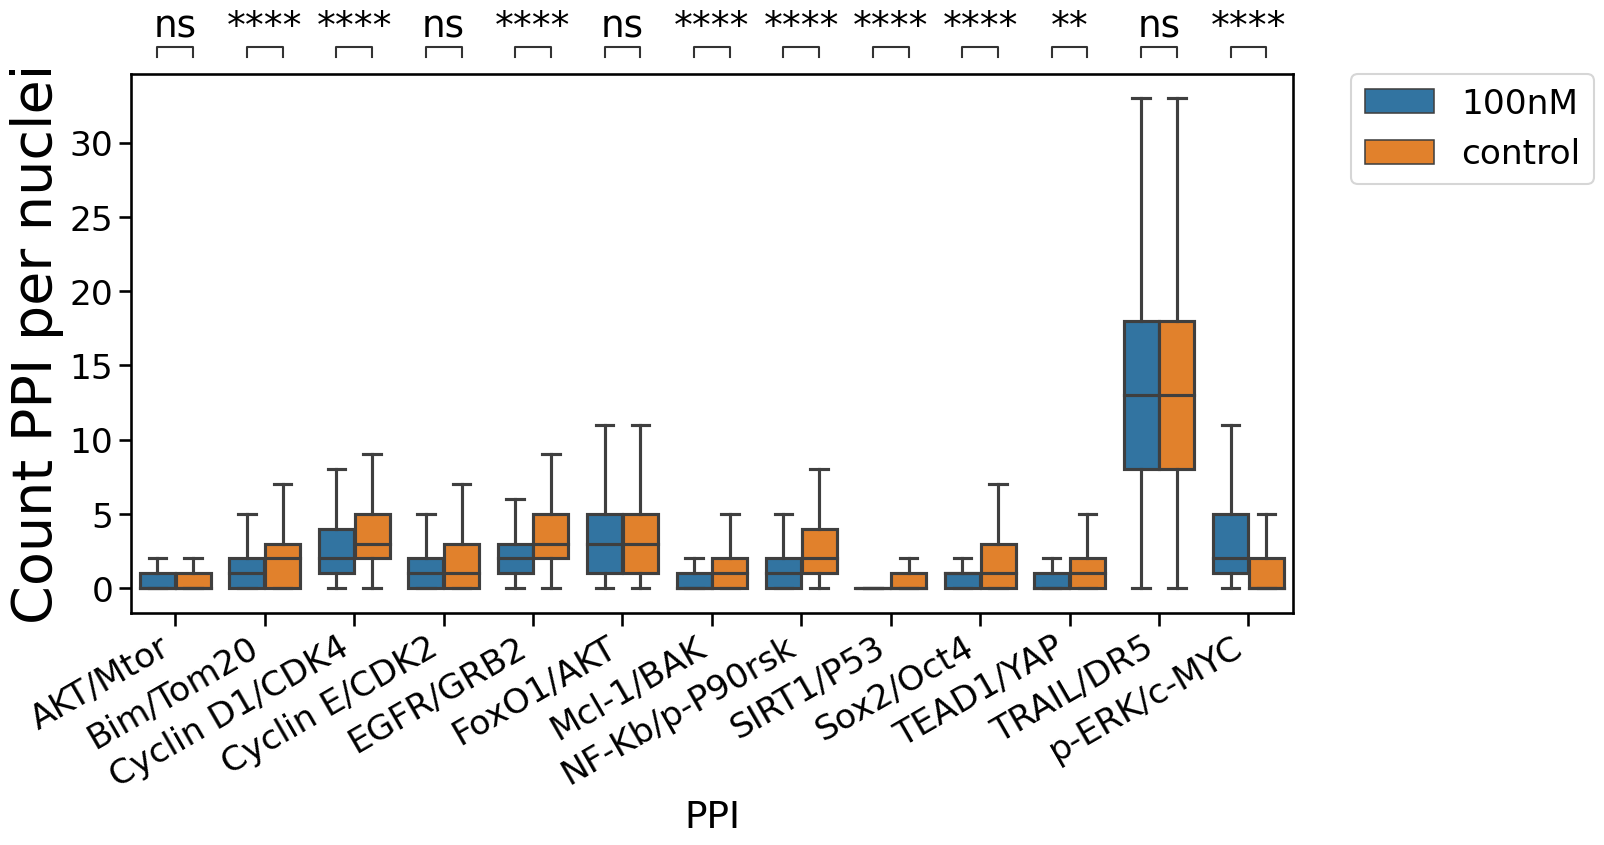

In [26]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_nuclei",
    "hue": "Condition"
}

plot(plotting, y_title='Count PPI per nuclei')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Sox2/Oct4_100nM vs. Sox2/Oct4_control: Mann-Whitney-Wilcoxon test two-sided, P_val:9.094e-23 U_stat=3.781e+05
TEAD1/YAP_100nM vs. TEAD1/YAP_control: Mann-Whitney-Wilcoxon test two-sided, P_val:6.485e-01 U_stat=4.977e+05
TRAIL/DR5_100nM vs. TRAIL/DR5_control: Mann-Whitney-Wilcoxon test two-sided, P_val:1.241e-01 U_stat=4.833e+05
p-ERK/c-MYC_100nM vs. p-ERK/c-MYC_control: Mann-Whitney-Wilcoxon test two-sided, P_val:3.821e-82 U_stat=7.461e+05
SIRT1/P53_100nM vs. SIRT1/P53_control: Mann-Whitney-Wilcoxon test two-sided, P_val:2.544e-01 U_stat=5.147e+05
Bim/Tom20_100nM vs. Bim/Tom20_control: Mann-Whitney-Wilcoxon test two-sided, P_val:1.940e-02 U_stat=4.737e+05
AKT/Mtor_100nM vs. AKT/Mtor_control: Mann-Whitney-Wilcoxon test two-sided, P_val:2.799e-11 U_stat=5.810e+05
Cyclin D1/CDK4_100nM vs. Cyclin D1/C

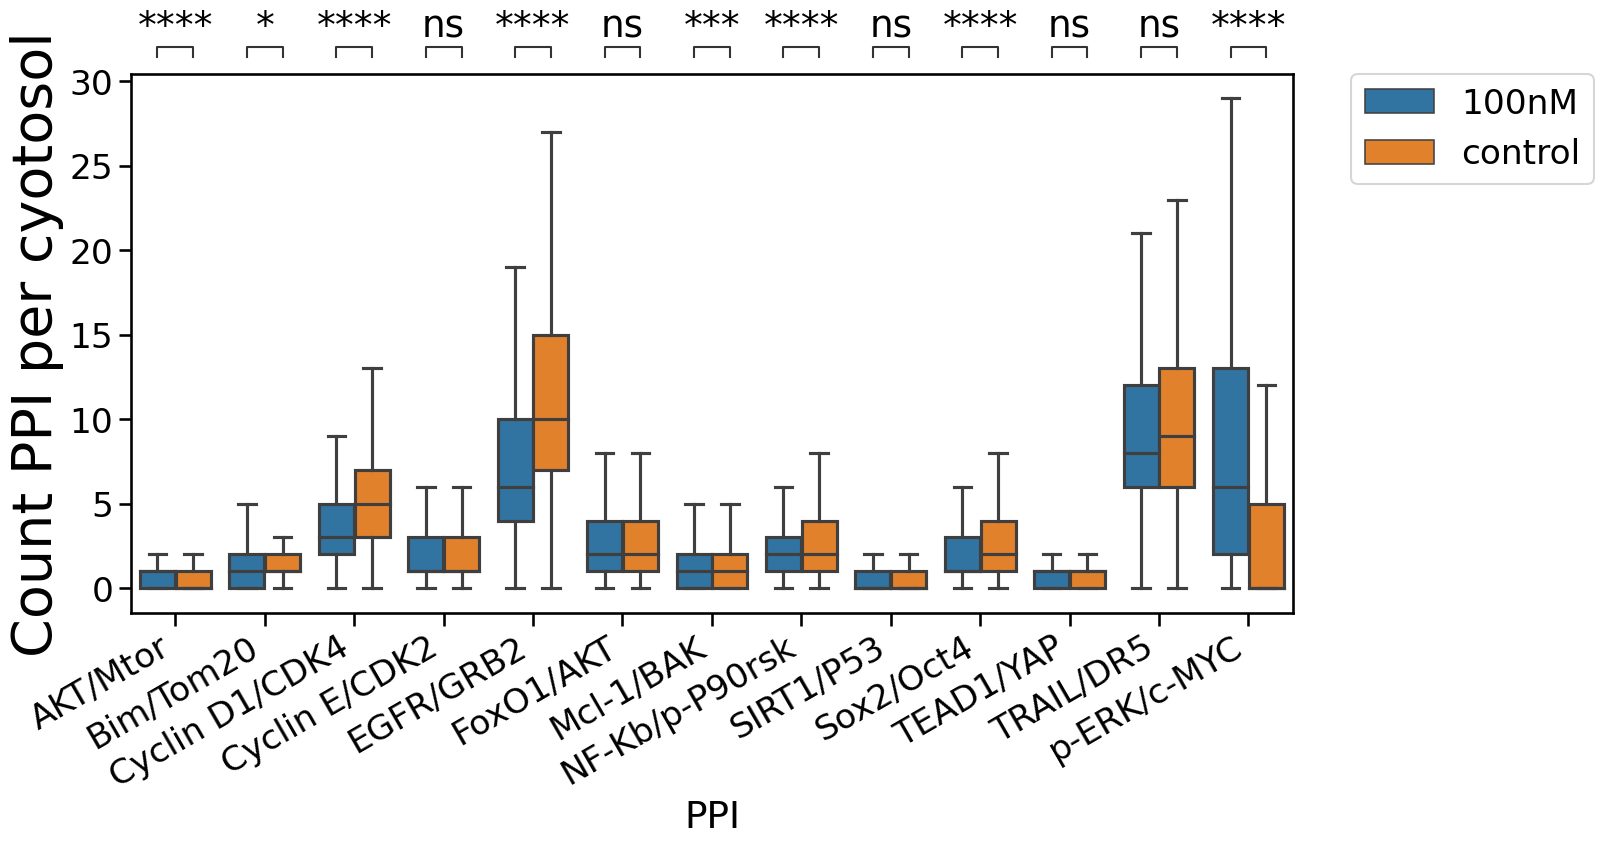

In [27]:
# Boxplot per cell
plotting = {
    "data": df_all,
    "x": "PPI",
    "y": "Count_cyto",
    "hue": "Condition"
}

plot(plotting, y_title='Count PPI per cyotosol')

# Comparison of distribution 

In [15]:
df_subset = df_all[(df_all.Condition == 'control') & (df_all.FOV == 'FW2')]

In [33]:
df_all.PPI.unique()

array(['AKT/Mtor', 'Bim/Tom20', 'Cyclin D1/CDK4', 'Cyclin E/CDK2',
       'EGFR/GRB2', 'FoxO1/AKT', 'Mcl-1/BAK', 'NF-Kb/p-P90rsk',
       'SIRT1/P53', 'Sox2/Oct4', 'TEAD1/YAP', 'TRAIL/DR5', 'p-ERK/c-MYC'],
      dtype=object)

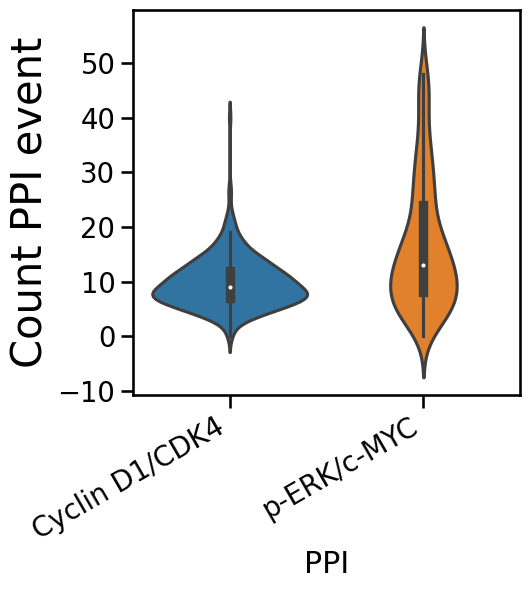

In [36]:
with sns.plotting_context('talk', font_scale=1.2):
    fig, ax = plt.subplots(figsize=(5,5))
    sns.violinplot(data=df_subset[df_subset.PPI.isin(['Cyclin D1/CDK4', 'p-ERK/c-MYC'])], x="PPI", y="Count_cell", ax=ax, density_norm='count')
    ax.set_ylabel('Count PPI event', fontsize=30)
    plt.xticks(rotation=30, ha='right')

## Comparison nuclei vs cytosol

In [55]:
# Boxplot per loc
df_melt = df_all.melt(id_vars=['Condition', 'PPI'], 
                      value_vars=['Count_nuclei', 'Count_cyto'],
                     var_name='LOC',
                     value_name='Count')


df_melt['Count'] = df_melt['Count'].clip(0, upper=None)
df_melt.Condition.unique()

array(['100nM', 'control'], dtype=object)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Sox2/Oct4_Count_nuclei vs. Sox2/Oct4_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.700e-125 U_stat=1.378e+05
TEAD1/YAP_Count_nuclei vs. TEAD1/YAP_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.023e-102 U_stat=8.207e+04
TRAIL/DR5_Count_nuclei vs. TRAIL/DR5_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:9.801e-63 U_stat=2.000e+05
p-ERK/c-MYC_Count_nuclei vs. p-ERK/c-MYC_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:7.420e-66 U_stat=2.436e+04
SIRT1/P53_Count_nuclei vs. SIRT1/P53_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:1.930e-104 U_stat=3.140e+04
Bim/Tom20_Count_nuclei vs. Bim/Tom20_Count_cyto: Mann-Whitney-Wilcoxon test two-sided, P_val:9.993e-98 U_stat=1.430e+05
AKT/Mtor_Count_nuclei vs. AKT/Mtor_Count_cyto: Mann-Whitney-Wilcoxon test two-sid

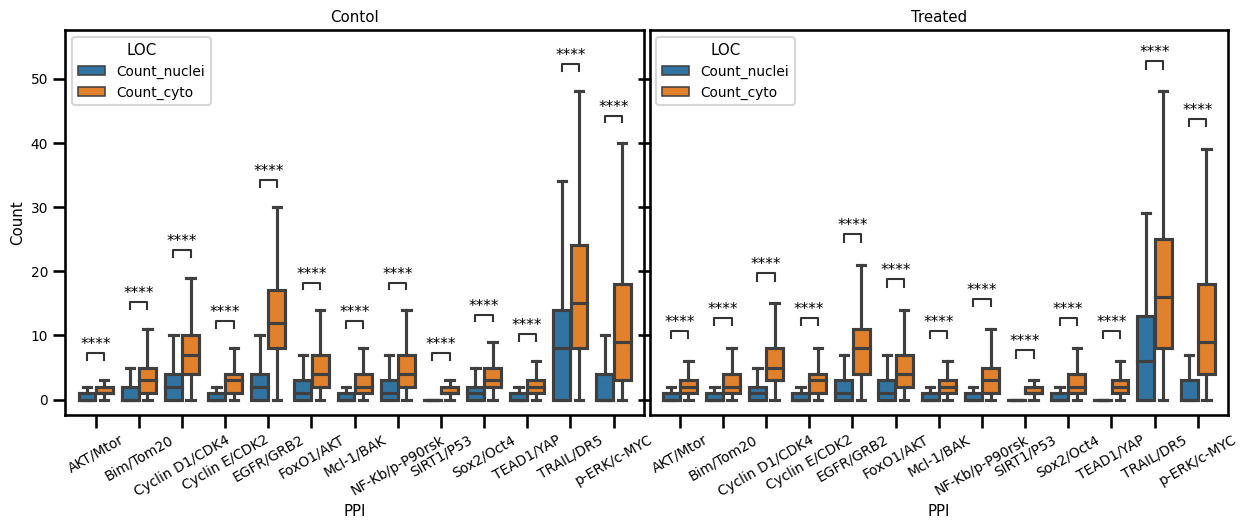

In [22]:

with sns.plotting_context('talk', font_scale=0.6):
    fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
    
    # Left figure
    df_subset = df_melt[df_melt.Condition == 'control']
    
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[0])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[0].tick_params(axis='x', rotation=30)
    
    # Right figure

    df_subset = df_melt[df_melt.Condition == '100nM']
    plotting = {
        "data": df_subset,
        "x": "PPI",
        "y": "Count",
        "hue": "LOC"
    }

    c1, c2 = df_subset[plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in df_subset[plotting['x']].unique()]
    ax = sns.boxplot(**plotting, showfliers=False, ax=axs[1])
    annot = Annotator(ax, pairs, **plotting)
    annot.configure(test='Mann-Whitney', text_format='star', verbose=2)
    result = annot.apply_test().annotate()
    axs[1].tick_params(axis='x', rotation=30)
    
    axs[0].set_title('Contol')
    axs[1].set_title('Treated')
    axs[1].set_ylabel('')
    fig.subplots_adjust(wspace=0.01)

## Detailed statistics

### Combined

In [18]:
df_combined = df_all.groupby(['Condition', 'FOV', 'Id'])[['Count_cell', 'Count_nuclei', 'Count_cyto']].agg('sum').reset_index()

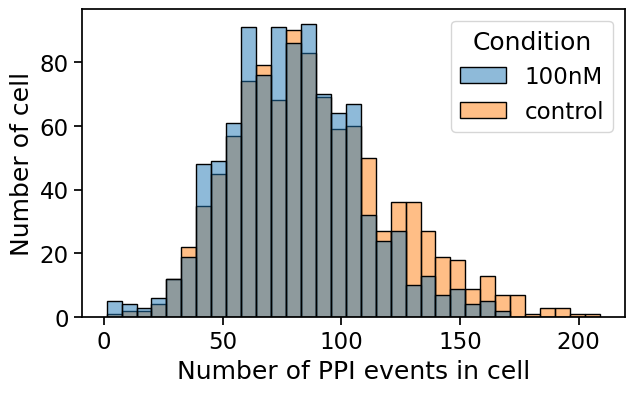

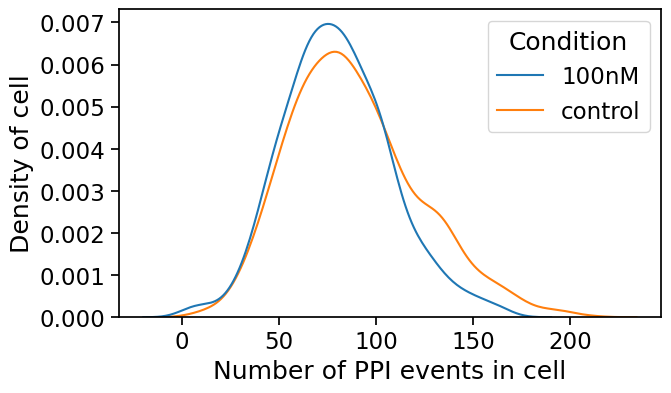

In [79]:
# Plot histo
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.histplot(data=df_combined, x='Count_cell', hue='Condition', ax=ax)
    ax.set_ylabel('Number of cell')
    ax.set_xlabel('Number of PPI events in cell')

# Plot kde
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.kdeplot(data=df_combined, x='Count_cell', hue='Condition', ax=ax)
    ax.set_ylabel('Density of cell')
    ax.set_xlabel('Number of PPI events in cell')    

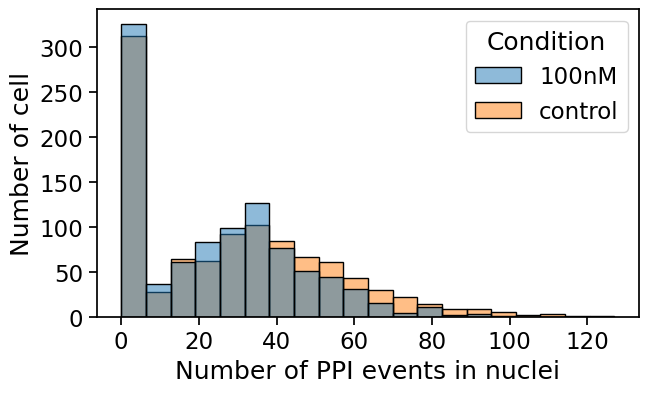

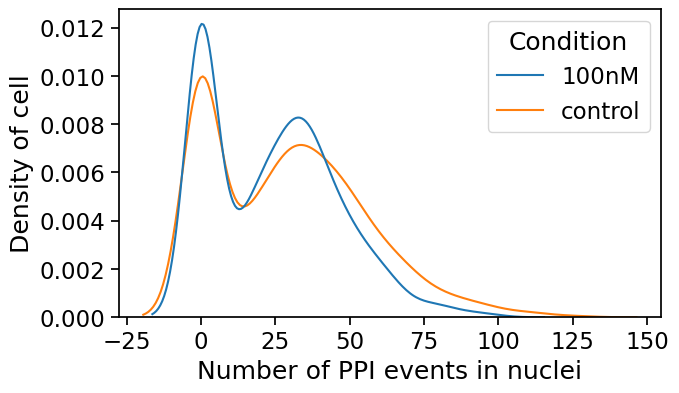

In [80]:
# Plot histo
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.histplot(data=df_combined, x='Count_nuclei', hue='Condition', ax=ax)
    ax.set_ylabel('Number of cell')
    ax.set_xlabel('Number of PPI events in nuclei')

# Plot kde
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.kdeplot(data=df_combined, x='Count_nuclei', hue='Condition', ax=ax)
    ax.set_ylabel('Density of cell')
    ax.set_xlabel('Number of PPI events in nuclei')    

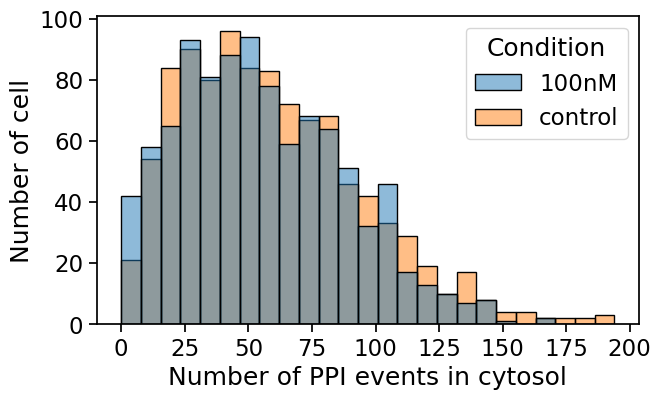

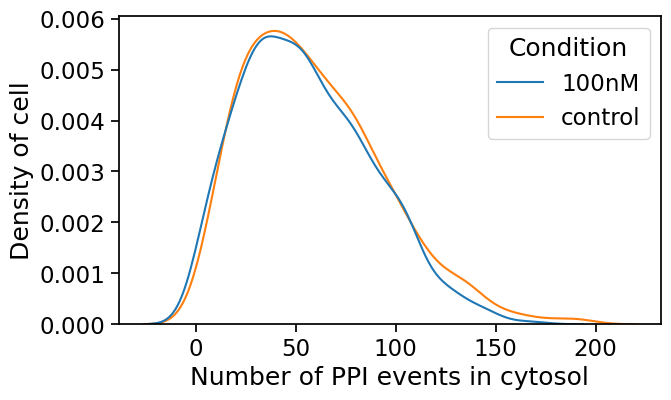

In [81]:
# Plot histo
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.histplot(data=df_combined, x='Count_cyto', hue='Condition', ax=ax)
    ax.set_ylabel('Number of cell')
    ax.set_xlabel('Number of PPI events in cytosol')

# Plot kde
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.kdeplot(data=df_combined, x='Count_cyto', hue='Condition', ax=ax)
    ax.set_ylabel('Density of cell')
    ax.set_xlabel('Number of PPI events in cytosol')    

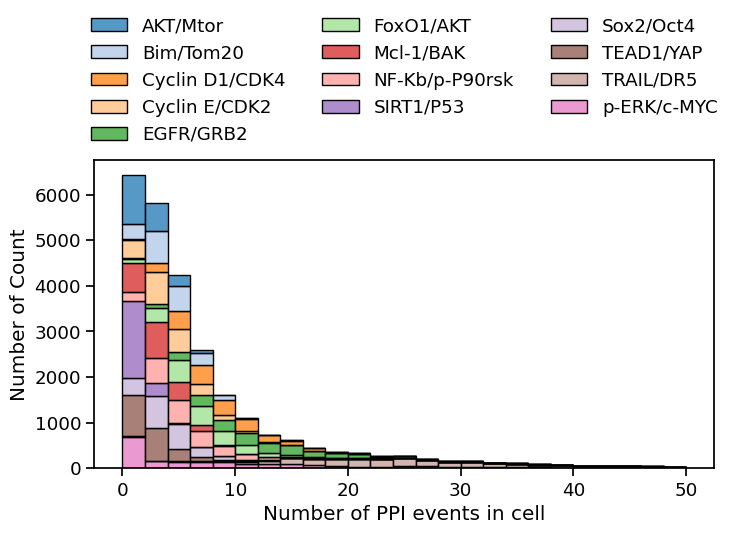

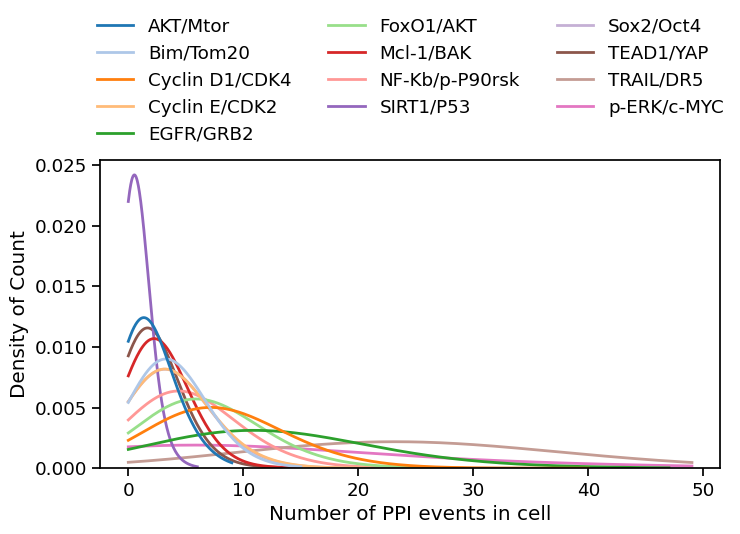

In [112]:
# Plot histo
with sns.plotting_context("notebook", font_scale=1.2):
    fig, ax = plt.subplots(figsize=(8,4))
    sns.histplot(data=df_all, x='Count_cell', hue='PPI', ax=ax, multiple="stack", palette='tab20', binwidth=2)
    ax.set_ylabel('Number of Count')
    ax.set_xlabel('Number of PPI events in cell')
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)


# Plot kde
with sns.plotting_context("notebook", font_scale=1.2):
    fig, ax = plt.subplots(figsize=(8,4))
    sns.kdeplot(data=df_all, x='Count_cell', hue='PPI', ax=ax, palette='tab20', cut=0, bw_adjust=5, lw=2)
    ax.set_ylabel('Density of Count')
    ax.set_xlabel('Number of PPI events in cell')    
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

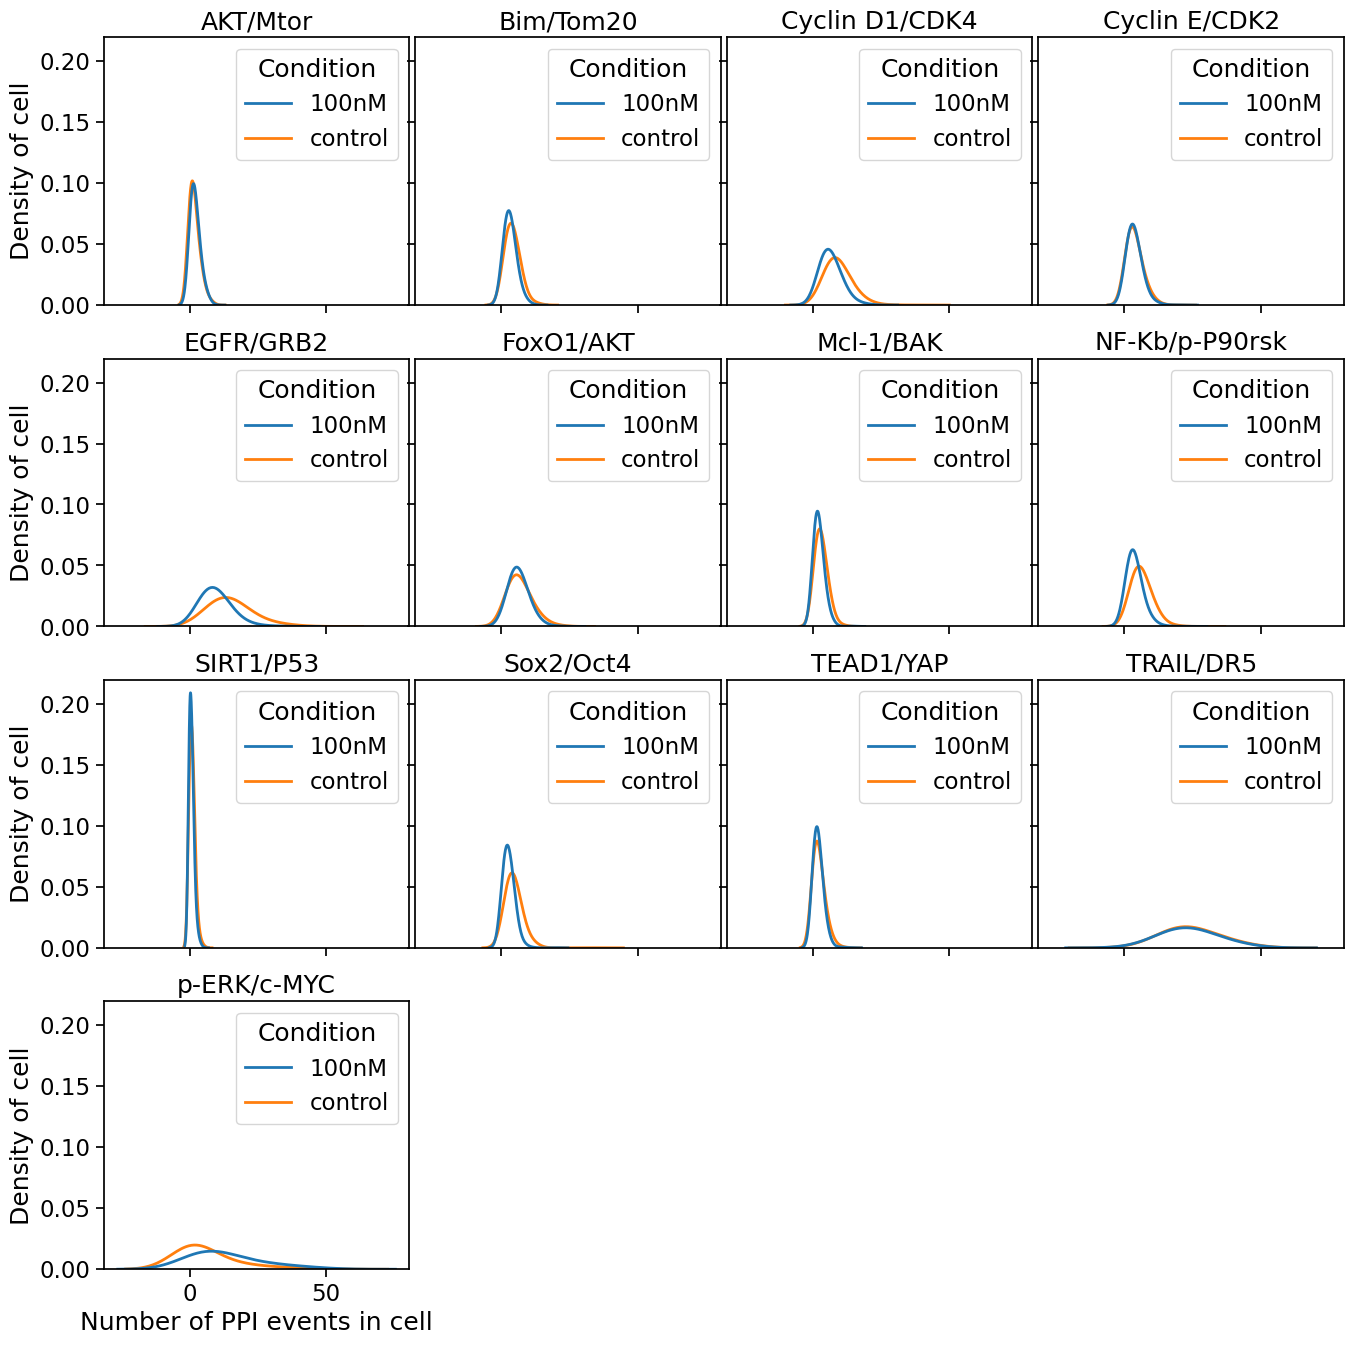

In [30]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, axs = plt.subplots(4, 4, figsize=(16,16), sharex=True, sharey=True)
    axs = axs.flatten()
    for i, PPI in enumerate(df_all.PPI.unique()):
        df_subset = df_all[df_all.PPI == PPI]
        # Plot kde
        sns.kdeplot(data=df_subset, x='Count_cell', hue='Condition', ax=axs[i], bw_adjust=3, lw=2)
        axs[i].set_title(PPI)
        if i % 4 == 0:
            axs[i].set_ylabel('Density of cell')
        if i > 10:
            axs[i].set_xlabel(f'Number of PPI events in cell')
    for i in range(13, 16):
        axs[i].axis('off')   
    fig.subplots_adjust(wspace=0.02)
    plt.show()

In [12]:
df_table = df_all.pivot_table(values='Count_cell', index=['Condition', 'FOV', 'Id'], columns='PPI').reset_index()

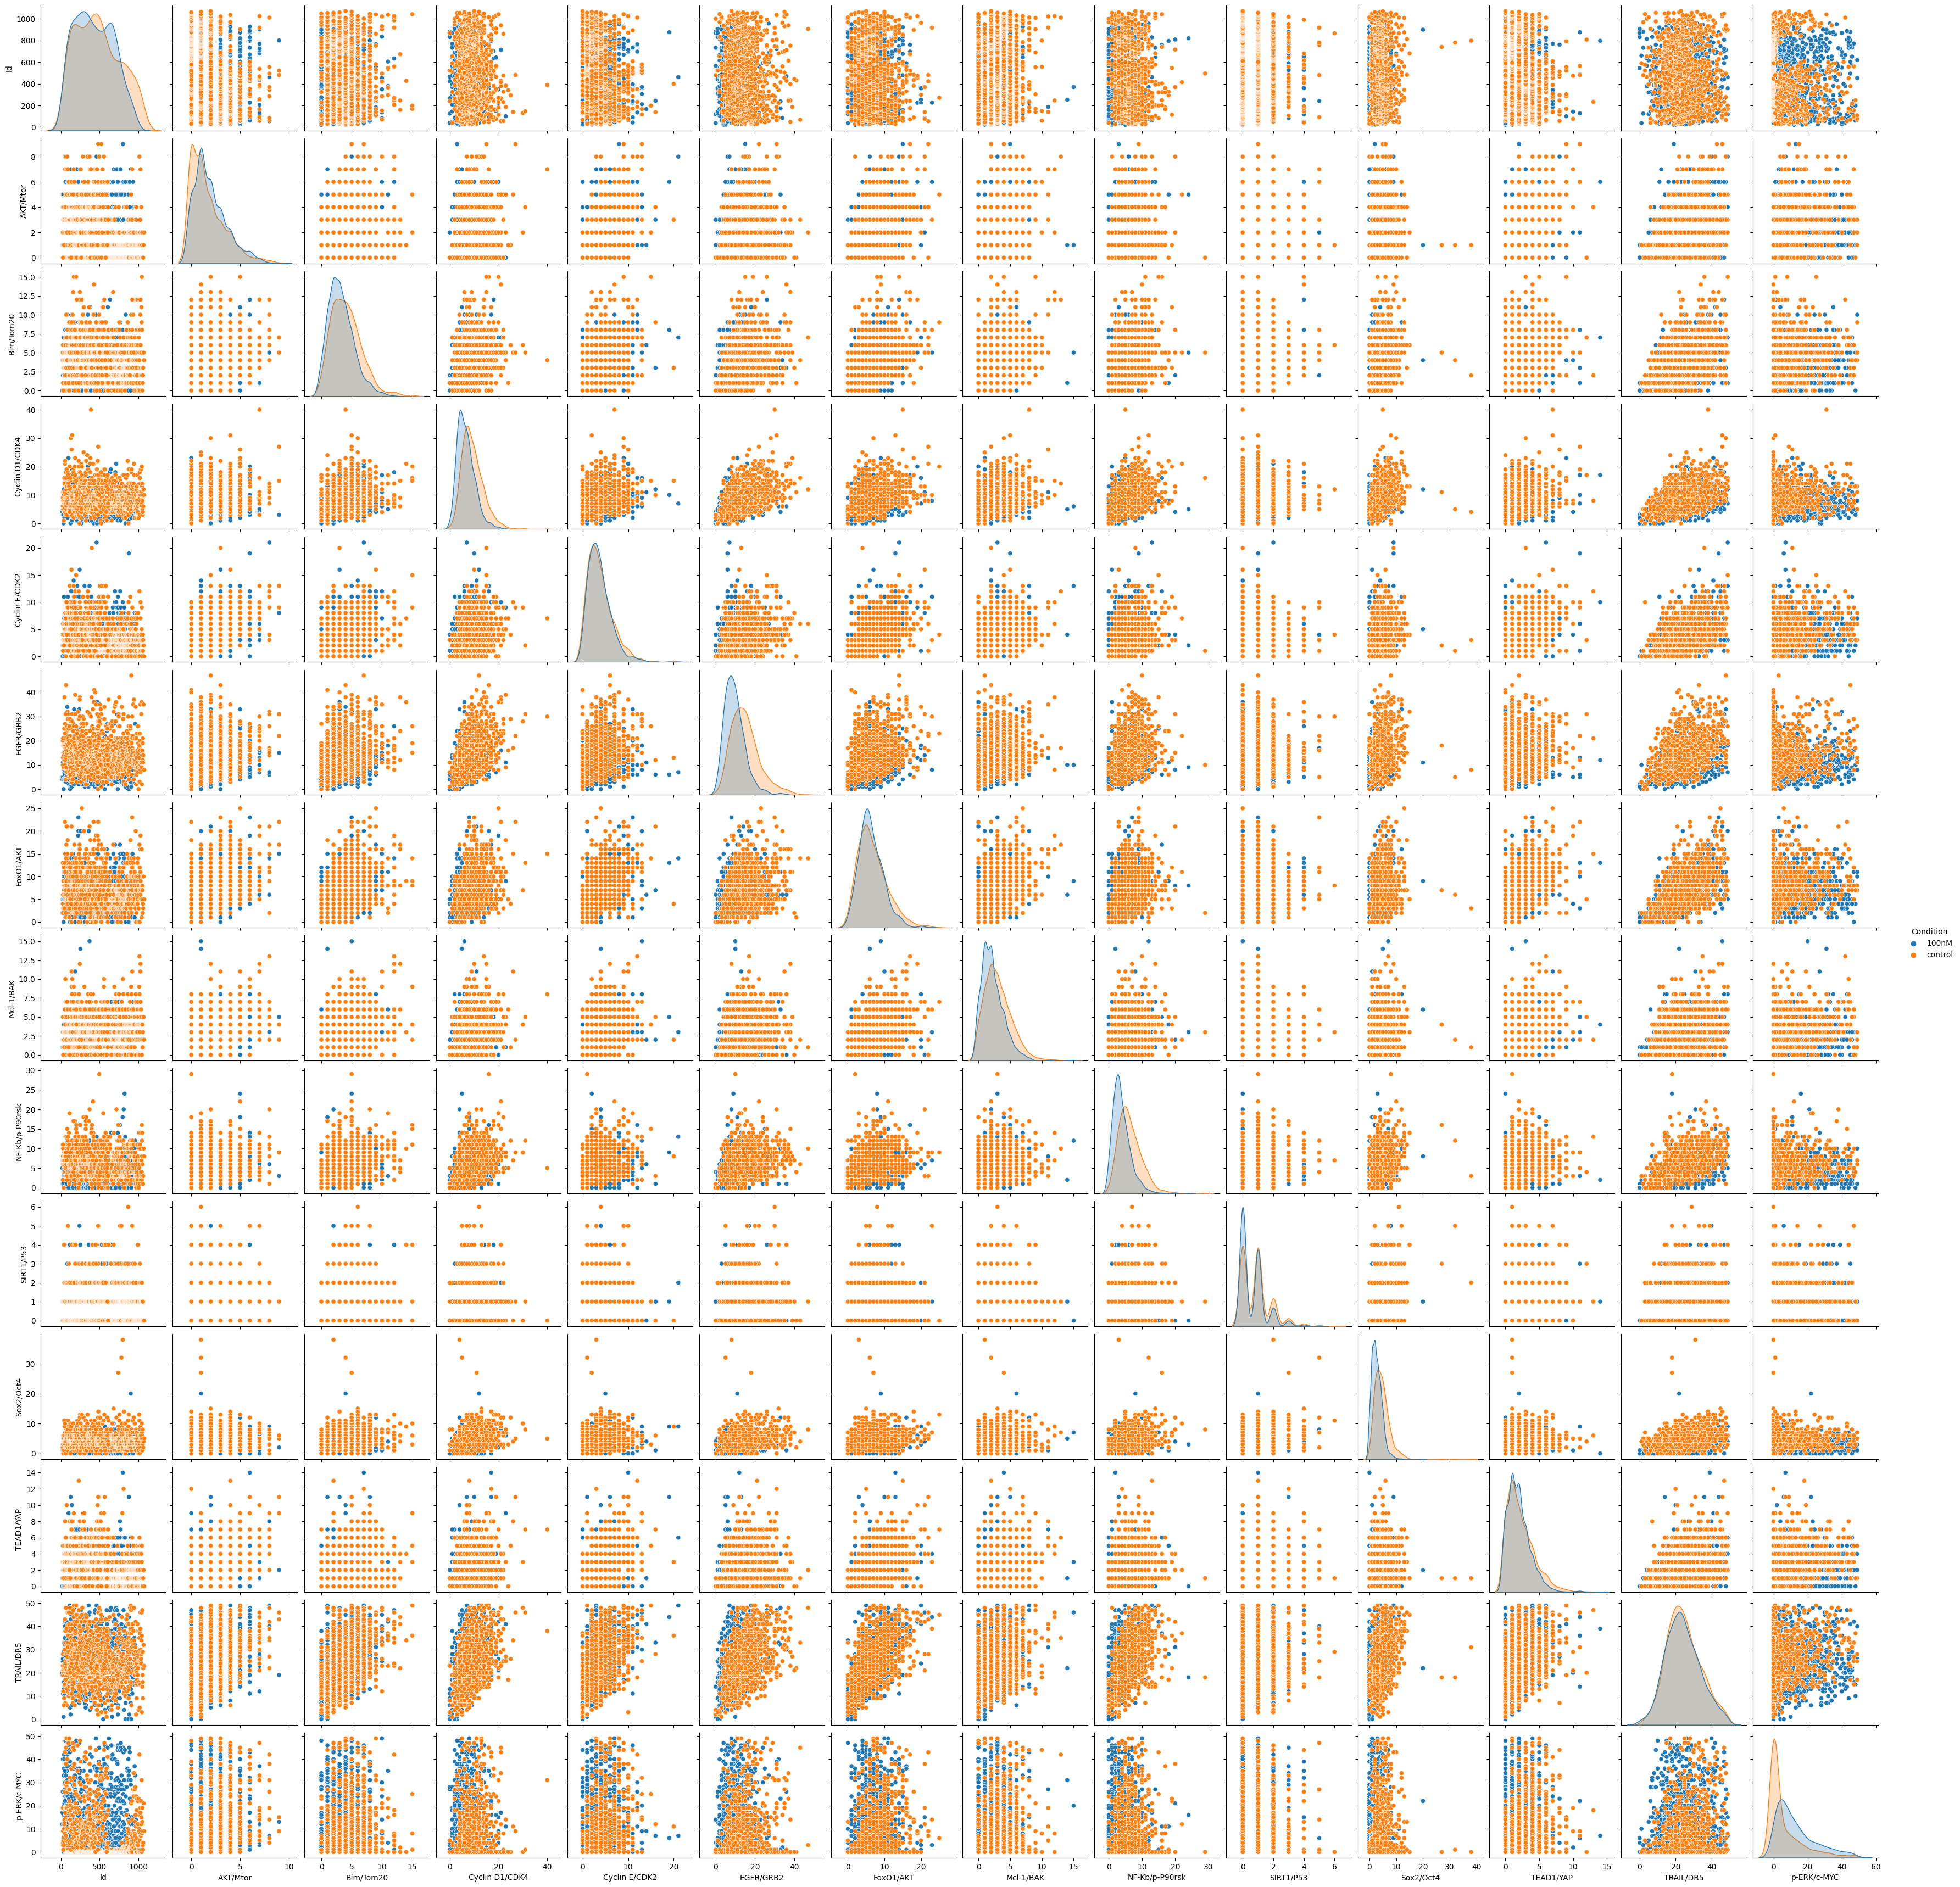

In [16]:
g = sns.pairplot(df_table, hue="Condition", diag_kind="kde", height=2.5)
plt.show()

### Control

In [113]:
df_control = df_all[df_all.Condition == 'control']
df_control.head()

Condition  FOV  Id       PPI  Count_cell  Count_nuclei  Count_cyto
1110   control  FW1  58  AKT/Mtor         1.0             0         1.0
1111   control  FW1  59  AKT/Mtor         0.0             0         0.0
1112   control  FW1  60  AKT/Mtor         2.0             0         2.0
1114   control  FW1  62  AKT/Mtor         1.0             1         0.0
1115   control  FW1  66  AKT/Mtor         0.0             0         0.0

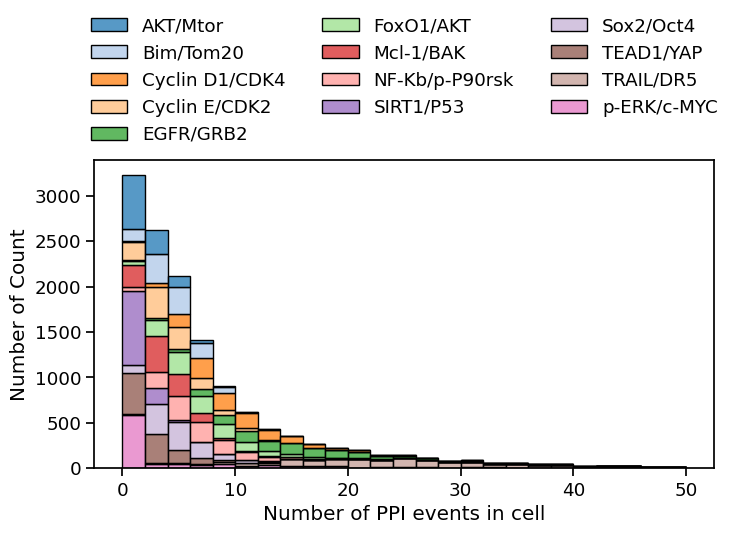

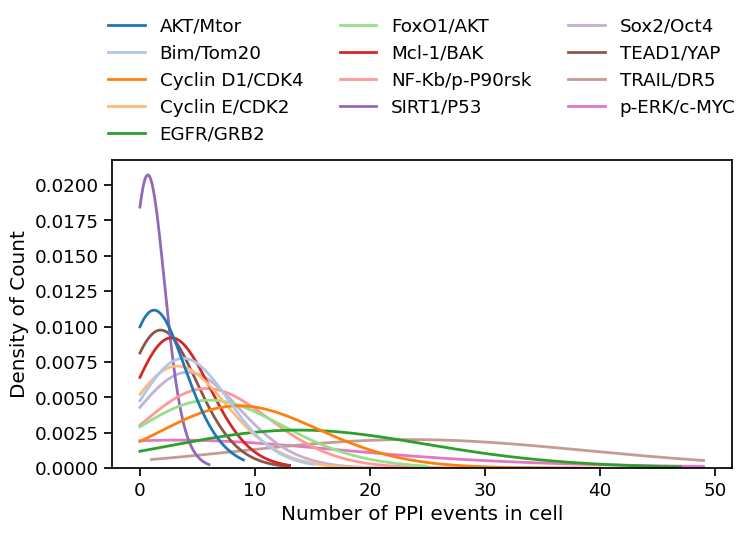

In [114]:
# Plot histo
with sns.plotting_context("notebook", font_scale=1.2):
    fig, ax = plt.subplots(figsize=(8,4))
    sns.histplot(data=df_control, x='Count_cell', hue='PPI', ax=ax, multiple="stack", palette='tab20', binwidth=2)
    ax.set_ylabel('Number of Count')
    ax.set_xlabel('Number of PPI events in cell')
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)


# Plot kde
with sns.plotting_context("notebook", font_scale=1.2):
    fig, ax = plt.subplots(figsize=(8,4))
    sns.kdeplot(data=df_control, x='Count_cell', hue='PPI', ax=ax, palette='tab20', cut=0, bw_adjust=5, lw=2)
    ax.set_ylabel('Density of Count')
    ax.set_xlabel('Number of PPI events in cell')    
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

In [115]:
df = df_control.pivot_table(values='Count_cell', index='Id', columns='PPI').fillna(0)
df.head()

PPI  AKT/Mtor  Bim/Tom20  Cyclin D1/CDK4  Cyclin E/CDK2  EGFR/GRB2  FoxO1/AKT  \
Id                                                                              
27        2.0        5.0             9.0            4.0       20.0       13.0   
28        4.0        6.0             6.0            6.0       10.0        4.0   
29        0.0        4.0            11.0            6.0       13.0        6.0   
30        0.0        1.0             8.0            1.0       21.0        2.0   
32        1.0        0.0             5.0            3.0       18.0        3.0   

PPI  Mcl-1/BAK  NF-Kb/p-P90rsk  SIRT1/P53  Sox2/Oct4  TEAD1/YAP  TRAIL/DR5  \
Id                                                                           
27         2.0             2.0        1.0        2.0        3.0       21.0   
28         5.0            11.0        0.0        3.0        5.0       23.0   
29         3.0             8.0        1.0        3.0        3.0       28.0   
30         2.0            10.0        0.0        0.0        1.0       19.0   
32         0.0             6.0        1.0        0.0        2.0       12.0   

PPI  p-ERK/c-MYC  
Id                
27          19.0  
28           3.0  
29           9.0  
30           4.0  
32           1.0

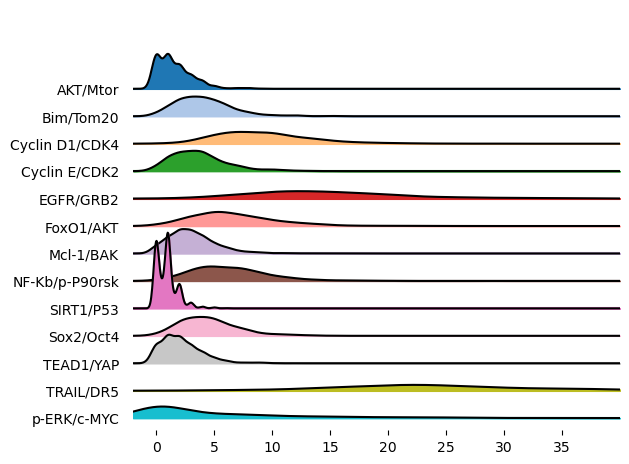

In [136]:
import joypy
from matplotlib import cm

df = df_control.pivot_table(values='Count_cell', index='Id', columns='PPI').fillna(0)
fig, axes = joypy.joyplot(df, colormap=cm.tab20, x_range=[-2, 40],bins=30)

### treated

In [139]:
df_treated = df_all[df_all.Condition == '100nM']
df_treated.head()

Condition  FOV  Id       PPI  Count_cell  Count_nuclei  Count_cyto
0     100nM  FW1  36  AKT/Mtor         0.0             0         0.0
1     100nM  FW1  37  AKT/Mtor         5.0             2         3.0
2     100nM  FW1  41  AKT/Mtor         3.0             2         1.0
3     100nM  FW1  47  AKT/Mtor         3.0             3         0.0
5     100nM  FW1  53  AKT/Mtor         3.0             1         2.0

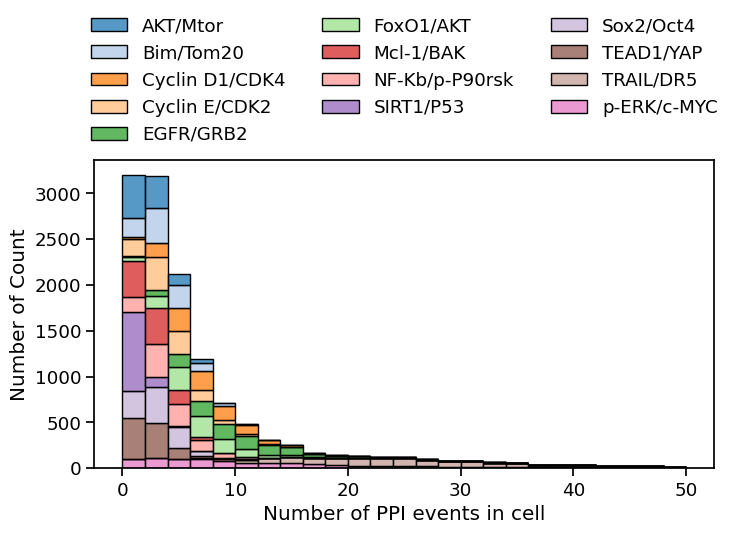

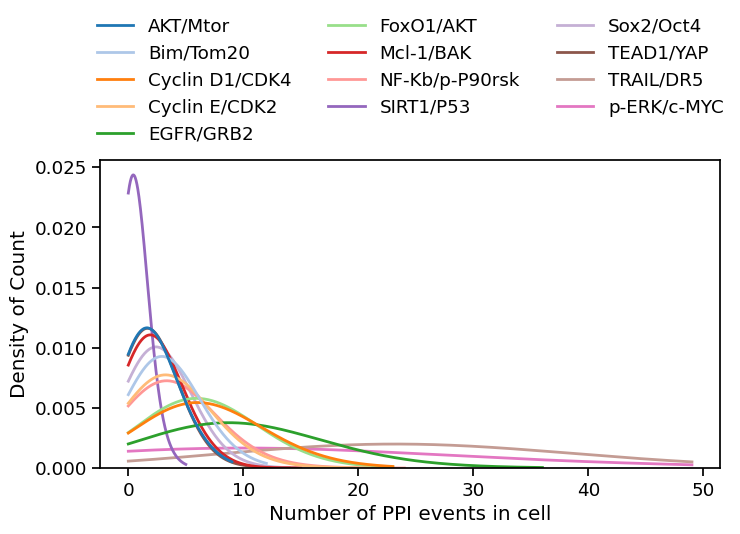

In [140]:
# Plot histo
with sns.plotting_context("notebook", font_scale=1.2):
    fig, ax = plt.subplots(figsize=(8,4))
    sns.histplot(data=df_treated, x='Count_cell', hue='PPI', ax=ax, multiple="stack", palette='tab20', binwidth=2)
    ax.set_ylabel('Number of Count')
    ax.set_xlabel('Number of PPI events in cell')
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)


# Plot kde
with sns.plotting_context("notebook", font_scale=1.2):
    fig, ax = plt.subplots(figsize=(8,4))
    sns.kdeplot(data=df_treated, x='Count_cell', hue='PPI', ax=ax, palette='tab20', cut=0, bw_adjust=5, lw=2)
    ax.set_ylabel('Density of Count')
    ax.set_xlabel('Number of PPI events in cell')    
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

In [143]:
df = df_treated.pivot_table(values='Count_cell', index='Id', columns='PPI').fillna(0)
df.head()

PPI  AKT/Mtor  Bim/Tom20  Cyclin D1/CDK4  Cyclin E/CDK2  EGFR/GRB2  FoxO1/AKT  \
Id                                                                              
21        1.0        0.0             4.0            0.0        5.0        2.0   
22        1.0        4.0             4.0            2.0        4.0        4.0   
26        1.0        2.0             5.0            0.0       10.0        5.0   
27        5.0        4.0             6.0            2.0       11.0        4.0   
29        1.0        2.0             3.0            2.0        5.0        3.0   

PPI  Mcl-1/BAK  NF-Kb/p-P90rsk  SIRT1/P53  Sox2/Oct4  TEAD1/YAP  TRAIL/DR5  \
Id                                                                           
21         2.0             5.0        0.0        2.0        0.0       19.0   
22         1.0             1.0        1.0        1.0        1.0       20.0   
26         2.0             7.0        1.0        3.0        2.0       25.0   
27         2.0             6.0        0.0        1.0        3.0       26.0   
29         1.0             1.0        0.0        1.0        2.0       11.0   

PPI  p-ERK/c-MYC  
Id                
21          12.0  
22          17.0  
26          26.0  
27          40.0  
29           4.0

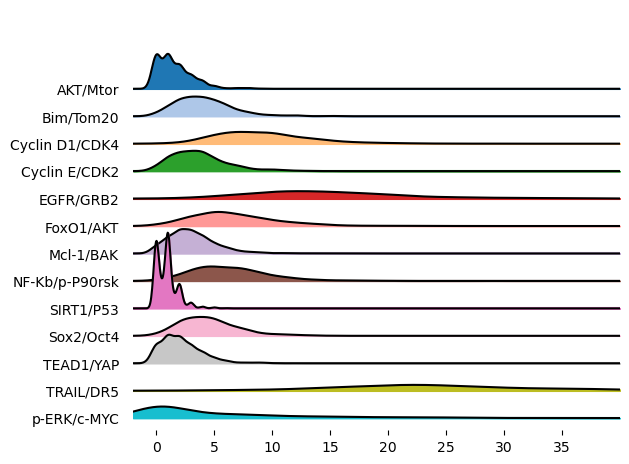

In [144]:
import joypy
from matplotlib import cm

df = df_control.pivot_table(values='Count_cell', index='Id', columns='PPI').fillna(0)
fig, axes = joypy.joyplot(df, colormap=cm.tab20, x_range=[-2, 40],bins=30)